In [1]:
# imports
# packages used
import librosa
import os 

import math
import numpy as np
import pandas as pd
import ast
import re

# import dask.array as da
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm, trange
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

Possible bias for this project: manually convert 59 genres into 4 quadrant. Might be bias.

## Need to Balance Data

There are 59 different genres contained in labels. If the data won't balanced, the results will be biased and prefer to present the genre with more data contained in the training set.

In [2]:
X = np.load("mtg-jamendo-dataset/prepare_data/large_X.npy") # (14020, 204, 1000)
y = np.load("mtg-jamendo-dataset/prepare_data/large_y.npy") # (14020,)

But before balancing data, we want to first convert the 59 genres to the 4 quadrant manually. Based on this chart:

<img src="59labels.jpg" style="width:600px; height: auto;">

After viewing the training based on this conversion, we found the results are all below 50%, decide to still train with 59 genres.

In [4]:
def map_labels(old_label):
    # Define label groups using sets for unique values and ranges for sequential values
    q1_labels = {1, 7, 8, 19, 20, 23, 24, 25, 26, 27, 29, 32, 38, 41, 42, 48, 54, 56, 57, 58}
    q2_labels = {0, 2, 9, 11, 14, 15, 16, 18, 21, 22, 28, 31, 39, 43, 53, 55}
    q3_labels = {4, 12, 13, 35, 47, 49, 51, 52}
    q4_labels = {3, 5, 6, 10, 17, 30, 33, 34, 36, 37, 40, 44, 45, 46, 50}

    # Check which set the label belongs to
    if old_label in q1_labels:
        return 0  # Q1
    elif old_label in q2_labels:
        return 1  # Q2
    elif old_label in q3_labels:
        return 2  # Q3
    elif old_label in q4_labels:
        return 3  # Q4
    else:
        raise ValueError("Label out of range")

# Example usage:
print(map_labels(25))  # Output will be 0, corresponding to Q1

0


In [7]:
# Map the labels
new_y = np.vectorize(map_labels)(y)

In [4]:
unique, counts = np.unique(y, return_counts=True)
label_counts = dict(zip(unique, counts))

# Calculate the median number of samples per label
#median_count = int(np.median(list(label_counts.values())))
mean_count = int(np.mean(list(label_counts.values())))
#print("Median samples per label:", median_count)
print("Mean samples per label:", mean_count)

Mean samples per label: 237


We will use the mean samples per label to do the data balancing.

In [5]:
X_balanced = []
y_balanced = []

# Iterate over each unique label and resample
for label in unique:
    # Find indices where the label occurs
    indices = np.where(y == label)[0]
    #print(indices)

    # Randomly choose `mean_count` samples or repeat if there are not enough
    if len(indices) > mean_count:
        selected_indices = np.random.choice(indices, mean_count, replace=False)
    else:
        selected_indices = np.random.choice(indices, mean_count, replace=True)
    
    # Append the resampled X and y data
    X_balanced.append(X[selected_indices])
    y_balanced.append(y[selected_indices])

In [6]:
# Convert lists to numpy arrays
X_balanced = np.vstack(X_balanced)

In [7]:
y_balanced = np.concatenate(y_balanced)

In [8]:
print(X_balanced.shape)
print(y_balanced.shape)

(13983, 204, 1000)
(13983,)


In [14]:
# Verify the balancing
unique, counts = np.unique(y_balanced, return_counts=True)
print(dict(zip(unique, counts)))

{0: 237, 1: 237, 2: 237, 3: 237, 4: 237, 5: 237, 6: 237, 7: 237, 8: 237, 9: 237, 10: 237, 11: 237, 12: 237, 13: 237, 14: 237, 15: 237, 16: 237, 17: 237, 18: 237, 19: 237, 20: 237, 21: 237, 22: 237, 23: 237, 24: 237, 25: 237, 26: 237, 27: 237, 28: 237, 29: 237, 30: 237, 31: 237, 32: 237, 33: 237, 34: 237, 35: 237, 36: 237, 37: 237, 38: 237, 39: 237, 40: 237, 41: 237, 42: 237, 43: 237, 44: 237, 45: 237, 46: 237, 47: 237, 48: 237, 49: 237, 50: 237, 51: 237, 52: 237, 53: 237, 54: 237, 55: 237, 56: 237, 57: 237, 58: 237}


In [9]:
np.save("mtg-jamendo-dataset/prepare_data/balanced_large_X_59.npy", X_balanced)
np.save("mtg-jamendo-dataset/prepare_data/balanced_large_y_59.npy", y_balanced)

## Load Dataset

In [2]:
X = np.load("mtg-jamendo-dataset/prepare_data/balanced_large_X_59.npy") # (14020, 204, 1000)
y = np.load("mtg-jamendo-dataset/prepare_data/balanced_large_y_59.npy") # (14020,)

In [3]:
y

array([ 0,  0,  0, ..., 58, 58, 58])

In [4]:
# convert array to tensor
X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y)
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: torch.Size([13983, 204, 1000])
y.shape: torch.Size([13983])


In [5]:
# Train, Validation, Test Split
# 7:2:1
# Stratified data
X_train_eval, X_test, y_train_eval, y_test = train_test_split(X, y, test_size=0.1, random_state=602, stratify=y)

# Train-Eval Split
X_train, X_eval, y_train, y_eval = train_test_split(X_train_eval, y_train_eval, test_size=2/9, random_state=602, stratify=y_train_eval)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_eval.shape: {X_eval.shape}")
print(f"y_eval.shape: {y_eval.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: torch.Size([9787, 204, 1000])
y_train.shape: torch.Size([9787])
X_eval.shape: torch.Size([2797, 204, 1000])
y_eval.shape: torch.Size([2797])
X_test.shape: torch.Size([1399, 204, 1000])
y_test.shape: torch.Size([1399])


In [6]:
# Normalization
# compute train set mean and std
train_mean_X = X_train.mean(dim=[0, 1, 2])
train_std_X = X_train.std(dim=[0, 1, 2])

# normalize X train, eval, test
X_train_norm = (X_train - train_mean_X) / train_std_X
X_eval_norm = (X_eval - train_mean_X) / train_std_X
X_test_norm = (X_test - train_mean_X) / train_std_X

In [7]:
# convert from int32 to int64 for later training
y_train = y_train.to(torch.int64)
y_eval = y_eval.to(torch.int64)
y_test = y_test.to(torch.int64)

In [8]:
# store torch data after split into local, save RAM
torch.save(X_train_norm, "mtg-jamendo-dataset/prepare_data/X_train_59.pt")
torch.save(y_train, "mtg-jamendo-dataset/prepare_data/y_train_59.pt")

torch.save(X_eval_norm, "mtg-jamendo-dataset/prepare_data/X_eval_59.pt")
torch.save(y_eval, "mtg-jamendo-dataset/prepare_data/y_eval_59.pt")

torch.save(X_test_norm, "mtg-jamendo-dataset/prepare_data/X_test_59.pt")
torch.save(y_test, "mtg-jamendo-dataset/prepare_data/y_test_59.pt")

Stored the splited train, eval, test sets in ratio 7:2:1, and normalized these data. Stored into files "X_train.pt", "y_train.py", "X_eval.pt", "y_eval.pt", "X_test.pt", "y_test.pt".

## Train Models

In [2]:
X_train = torch.load("mtg-jamendo-dataset/prepare_data/X_train_59.pt")
y_train = torch.load("mtg-jamendo-dataset/prepare_data/y_train_59.pt")

X_eval = torch.load("mtg-jamendo-dataset/prepare_data/X_eval_59.pt")
y_eval = torch.load("mtg-jamendo-dataset/prepare_data/y_eval_59.pt")

X_test = torch.load("mtg-jamendo-dataset/prepare_data/X_test_59.pt")
y_test = torch.load("mtg-jamendo-dataset/prepare_data/y_test_59.pt")

In [3]:
# Dataset Class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        y = self.y[idx]
        X = self.X[idx]
        return (X, y)

In [4]:
# X_train.transpose(1, 2).shape # X_train.transpose(1, 2).shape

In [5]:
# model needs a (9787, 1000, 204) shape instead (9787, 204, 1000)
X_train = X_train.transpose(1, 2)
X_eval  = X_eval.transpose(1, 2)
X_test  = X_test.transpose(1, 2)

train_data = MyDataset(X_train, y_train)
eval_data  = MyDataset(X_eval, y_eval)
test_data  = MyDataset(X_test, y_test)

## RNNs

In [14]:
### Xinyu(Xiyah) Chang ###

# Define RNN Model
# Need a input with shape (9814, 1000, 204)
class MusicEmotionRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MusicEmotionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True gives the input and output tensors in the format:
        # (batch, seq, feature) instead of (seq, batch, feature)
        # batch: 9814
        # seq: which is timestep, here should be 1000
        # feature: 204
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # Fully Connected Layer output the prediction
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2), # add droppout prevent overfit
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        # Initialize hidden and cell states
        # x.size(0) is batch size
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the RNN
        _, ht = self.rnn(x, h0)
        out = self.fc(ht[0])
        return out
### Xinyu(Xiyah) Chang ###

In [15]:
# Model Params
input_size = 204     # seq in (batch, seq, feature)
hidden_size = 128    # Can adjust based on model complexity and dataset, used: 128
num_layers = 1       # Number of RNN layers, 1 or 2, 1 is better by training
num_classes = 59      # 59 genres
learning_rate = 1e-4 # Can adjust this learing rate， 1e-4, 3e-4, 1e-3, 3e-3
num_epochs = 2000      # Number of epochs
batch_size = 128     # size of batch

rnn_model = MusicEmotionRNN(input_size, hidden_size, num_layers, num_classes)

In [16]:
# Use DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(dataset=eval_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Assuming use of CrossEntropyLoss and an optimizer Adam
criterion = nn.CrossEntropyLoss()

In [17]:
# Define the device 
# "cuda", "mps", "cpu"
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda')

# Move model to the chosen device
rnn_model = rnn_model.to(device)
optimizer = optim.AdamW(rnn_model.parameters(), lr=learning_rate)

total_batches = math.ceil( X_train.shape[0] / batch_size)
rnn_model.train()  

# record train acc and loss
rnn_train_acc = []
rnn_train_loss = []

# record eval acc
rnn_eval_acc = []

for epoch in trange(num_epochs):
    running_loss = 0.0
    prog = enumerate(train_loader) 

    # initialize accuracy count for each new epoch
    correct = 0
    total = 0

    for i, (inputs, labels) in prog:
        # Move data to the chosen device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = rnn_model(inputs)
        # labels = labels.long().to(device) # convert from int32 to int64
        loss = criterion(outputs, labels)

        # Zero the parameter gradients
        optimizer.zero_grad(set_to_none=False)

        # Backward pass and optimize
        loss.backward()

        # clip gradient to prevent explosion
        torch.nn.utils.clip_grad_norm_(rnn_model.parameters(), 20.0)
        optimizer.step()

        running_loss += loss.item()
        __, predicted = torch.max(outputs.data, dim=1)
        
        # record train acc for each batch loop
        correct += (predicted==labels).sum().item()
        total += labels.size(0)

    # calculate average loss and acc over training batches
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    rnn_train_acc.append(epoch_acc)
    rnn_train_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc_train: {epoch_acc:.4f}')

    # evaluate using eval for each epoch
    rnn_model.eval() 

    with torch.inference_mode():
        eval_correct=0
        eval_total=0
        for i, (inputs, labels) in enumerate(eval_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = rnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

        eval_accuracy = eval_correct / eval_total
        rnn_eval_acc.append(eval_accuracy)
        print(f'Validation Accuracy: {eval_accuracy:.4f}%')
    
    # set the model back to train mode
    rnn_model.train()

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1/2000, Loss: 4.1246, Acc_train: 0.0222
Validation Accuracy: 0.0247%
Epoch 2/2000, Loss: 4.0536, Acc_train: 0.0306
Validation Accuracy: 0.0340%
Epoch 3/2000, Loss: 4.0125, Acc_train: 0.0375
Validation Accuracy: 0.0425%
Epoch 4/2000, Loss: 3.9799, Acc_train: 0.0469
Validation Accuracy: 0.0515%
Epoch 5/2000, Loss: 3.9624, Acc_train: 0.0497
Validation Accuracy: 0.0583%
Epoch 6/2000, Loss: 3.9459, Acc_train: 0.0548
Validation Accuracy: 0.0608%
Epoch 7/2000, Loss: 3.9322, Acc_train: 0.0573
Validation Accuracy: 0.0651%
Epoch 8/2000, Loss: 3.9193, Acc_train: 0.0628
Validation Accuracy: 0.0644%
Epoch 9/2000, Loss: 3.9009, Acc_train: 0.0611
Validation Accuracy: 0.0697%
Epoch 10/2000, Loss: 3.8895, Acc_train: 0.0651
Validation Accuracy: 0.0711%
Epoch 11/2000, Loss: 3.8748, Acc_train: 0.0699
Validation Accuracy: 0.0711%
Epoch 12/2000, Loss: 3.8626, Acc_train: 0.0758
Validation Accuracy: 0.0747%
Epoch 13/2000, Loss: 3.8531, Acc_train: 0.0777
Validation Accuracy: 0.0740%
Epoch 14/2000, Loss: 

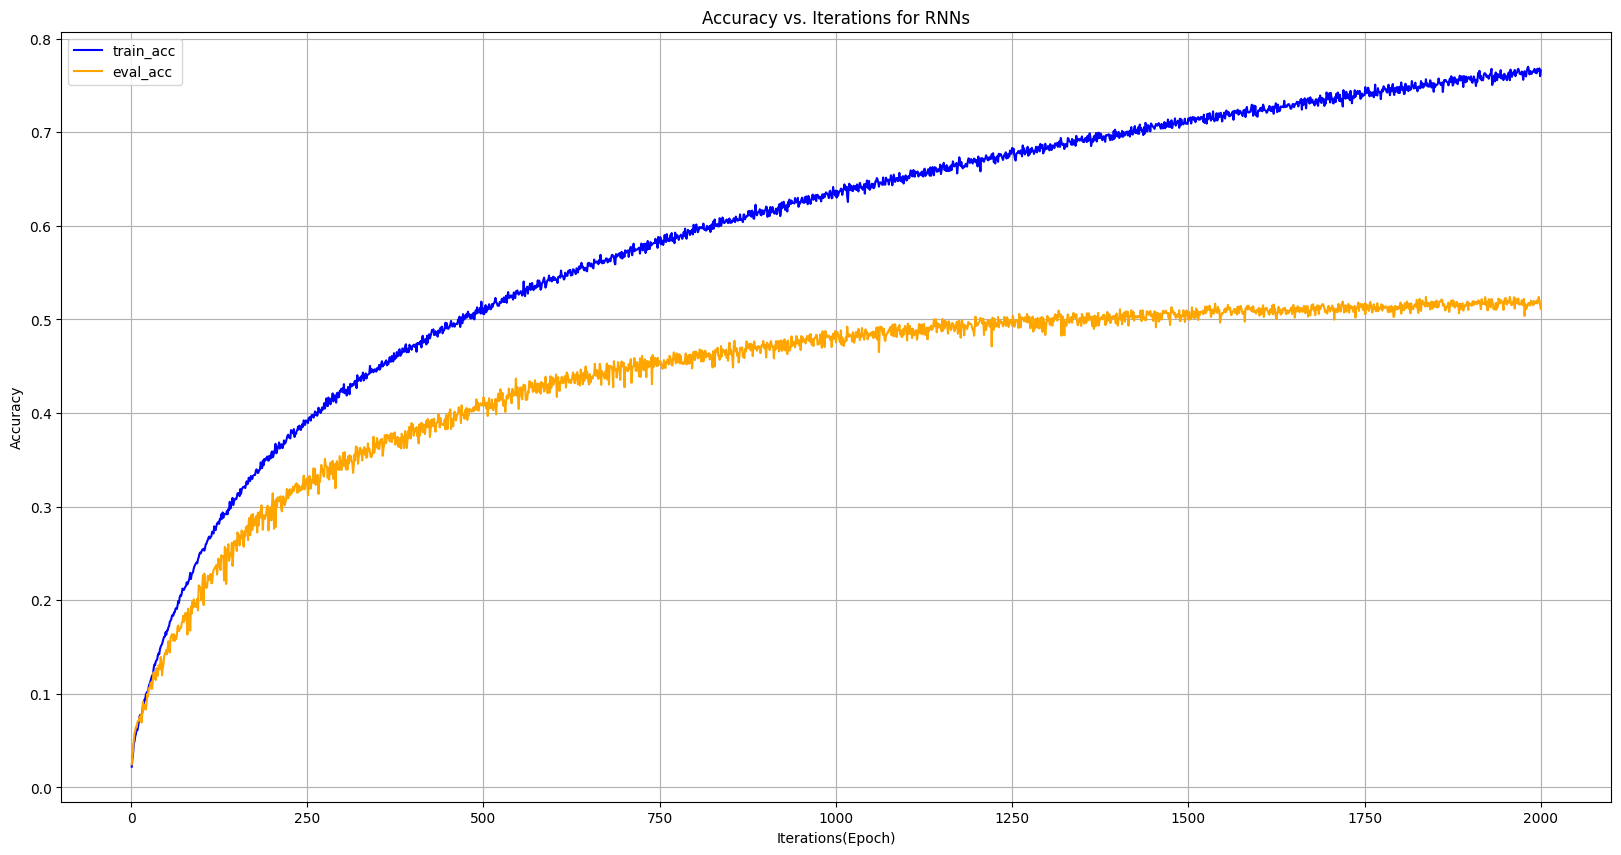

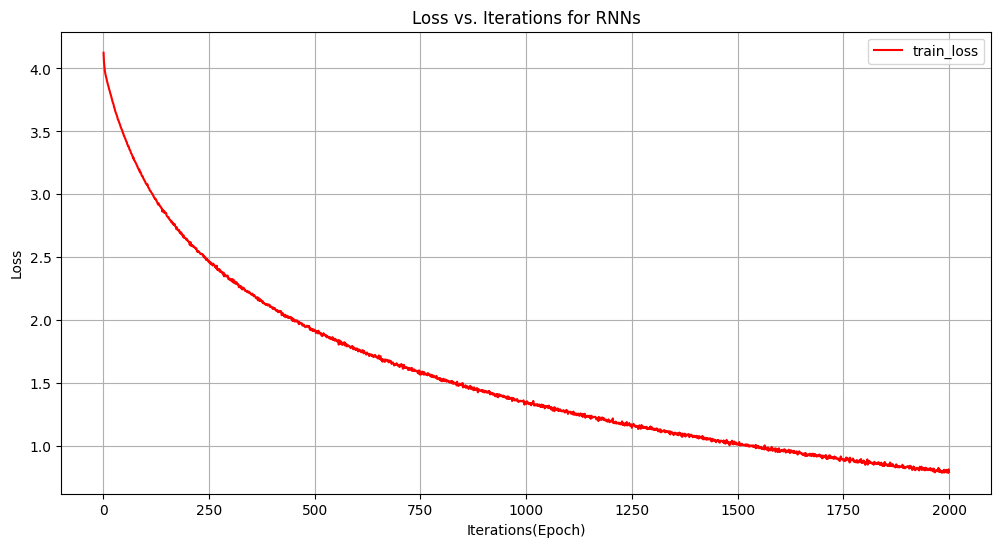

In [18]:
# plot train acc vs. iterations(epoch)
#num_epochs = 243
x_axis = list(range(1, num_epochs+1))
plt.figure(figsize=(20, 10))
plt.plot(x_axis, rnn_train_acc, color='blue')
plt.plot(x_axis, rnn_eval_acc, color='orange')
plt.xlabel('Iterations(Epoch)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iterations for RNNs')
plt.grid(True)
plt.legend(['train_acc', 'eval_acc'])
plt.show()

# plot train loss vs. iterations(epoch)
plt.figure(figsize=(12, 6))
plt.plot(x_axis, rnn_train_loss, color='red')
plt.xlabel('Iterations(Epoch)')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations for RNNs')
plt.grid(True)
plt.legend(['train_loss'])
plt.show()

In [19]:
# Evaluate the rnn model
rnn_model.eval()  
correct = 0
total = 0

with torch.inference_mode():
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = rnn_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        #print(outputs, predicted, labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Accuracy on the test set: 50.17869907076483%


## Bidirectional RNNs

In [9]:
### Xinyu(Xiyah) Chang ###

# Define Bidirectional-RNN Model
# Need a input with shape ( 9814, 1295, 204)
class MusicEmotionBiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MusicEmotionBiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True gives the input and output tensors in the format:
        # (batch, seq, feature) instead of (seq, batch, feature)
        # batch: 9814
        # seq: which is timestep, here should be 1000
        # feature: 204
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True) # add bidirectional
        # Fully Connected Layer output the prediction
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.1), # add droppout prevent overfit
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        # Initialize hidden and cell states
        # x.size(0) is batch size
        # Bidirectional Rnn returns 
        # h0: tensor of shape (2*Number of Layers, Batchsize, hidden_size)
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the RNN
        _, ht = self.rnn(x, h0)
        
        # Pass the hidden state of the last time step to the fc layer
        # ht should be (2*num_layers, batchsize, hidden_size)
        # here: (2, 128, 128)
        # will want to make this stack together to be a (128, 256)
        stack_ht = torch.cat((ht[0], ht[1]), dim=1)
        #print(f"after stack ht shape: {stack_ht.shape}")
        out = self.fc(stack_ht)
        return out
### Xinyu(Xiyah) Chang ###

In [10]:
# Model Params
input_size = 204     # seq in (batch, seq, feature)
hidden_size = 128    # Can adjust based on model complexity and dataset, used: 128
num_layers = 1       # Number of RNN layers, 1 or 2, 1 is better by training
num_classes = 59      # 59 quadrants
learning_rate = 3e-4 # Can adjust this learing rate， 1e-4, 3e-4, 1e-3, 3e-3
num_epochs = 2000      # Number of epochs
batch_size = 128     # size of batch

bi_rnn_model = MusicEmotionBiRNN(input_size, hidden_size, num_layers, num_classes)

# Use DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(dataset=eval_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Assuming use of CrossEntropyLoss and an optimizer Adam
criterion = nn.CrossEntropyLoss()

In [11]:
### Xinyu(Xiyah) Chang ###

# Define the device 
# "cuda", "mps", "cpu"
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda')

# Move model to the chosen device
bi_rnn_model = bi_rnn_model.to(device)
bi_rnn_optimizer = optim.AdamW(bi_rnn_model.parameters(), lr=learning_rate)

total_batches = math.ceil( X_train.shape[0] / batch_size)
#total_batches = 7
bi_rnn_model.train()  

# record train acc and loss
bi_rnn_train_acc = []
bi_rnn_train_loss = []

# record eval acc
bi_rnn_eval_acc = []

for epoch in trange(num_epochs):
    running_loss = 0.0
    prog = enumerate(train_loader) #tqdm(enumerate(train_loader), total=total_batches, desc=f'Epoch {epoch+1}/{num_epochs}')

    # initialize accuracy count for each new epoch
    correct = 0
    total = 0

    for i, (inputs, labels) in prog:
        # Move data to the chosen device
        # print(inputs)
        inputs, labels = inputs.to(device), labels.to(device)
        # print(inputs.shape)

        # Forward pass
        outputs = bi_rnn_model(inputs)
        # print(outputs.shape)
        # print(outputs, labels)
        # break
        loss = criterion(outputs, labels)

        # Zero the parameter gradients
        bi_rnn_optimizer.zero_grad(set_to_none=False)

        # Backward pass and optimize
        loss.backward()

        # clip gradient to prevent explosion
        torch.nn.utils.clip_grad_norm_(bi_rnn_model.parameters(), 20.0)
        bi_rnn_optimizer.step()

        running_loss += loss.item()
        __, predicted = torch.max(outputs.data, dim=1)
        # print(f"predicted: {predicted}")
        # print(f"labels: {labels}")
        # print((predicted==labels).sum())   # tensor(41, device='mps:0')
        correct += (predicted==labels).sum().item()                         # Easily getting Error!
                                                    # before modifying, this part I forgot to add up "total" for all batches loops
        total += labels.size(0)
        #print(ct_acc)

    # calculate average loss and acc over training batches
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    bi_rnn_train_acc.append(epoch_acc)
    bi_rnn_train_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc_train: {epoch_acc:.4f}')

    # evaluate using eval for each epoch
    bi_rnn_model.eval() 

    with torch.inference_mode():
        eval_correct=0
        eval_total=0
        for i, (inputs, labels) in enumerate(eval_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = bi_rnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

        eval_accuracy = eval_correct / eval_total
        bi_rnn_eval_acc.append(eval_accuracy)
        print(f'Validation Accuracy: {eval_accuracy:.4f}%')
    
    # set the model back to train mode
    bi_rnn_model.train()

### Xinyu(Xiyah) Chang ###

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1/2000, Loss: 4.0419, Acc_train: 0.0367
Validation Accuracy: 0.0536%
Epoch 2/2000, Loss: 3.9315, Acc_train: 0.0611
Validation Accuracy: 0.0665%
Epoch 3/2000, Loss: 3.8655, Acc_train: 0.0765
Validation Accuracy: 0.0779%
Epoch 4/2000, Loss: 3.8073, Acc_train: 0.0876
Validation Accuracy: 0.0833%
Epoch 5/2000, Loss: 3.7543, Acc_train: 0.1054
Validation Accuracy: 0.0969%
Epoch 6/2000, Loss: 3.7031, Acc_train: 0.1196
Validation Accuracy: 0.0976%
Epoch 7/2000, Loss: 3.6563, Acc_train: 0.1293
Validation Accuracy: 0.1244%
Epoch 8/2000, Loss: 3.6042, Acc_train: 0.1452
Validation Accuracy: 0.1133%
Epoch 9/2000, Loss: 3.5606, Acc_train: 0.1520
Validation Accuracy: 0.1248%
Epoch 10/2000, Loss: 3.5164, Acc_train: 0.1640
Validation Accuracy: 0.1244%
Epoch 11/2000, Loss: 3.4715, Acc_train: 0.1697
Validation Accuracy: 0.1502%
Epoch 12/2000, Loss: 3.4252, Acc_train: 0.1879
Validation Accuracy: 0.1530%
Epoch 13/2000, Loss: 3.3844, Acc_train: 0.1962
Validation Accuracy: 0.1620%
Epoch 14/2000, Loss: 

KeyboardInterrupt: 

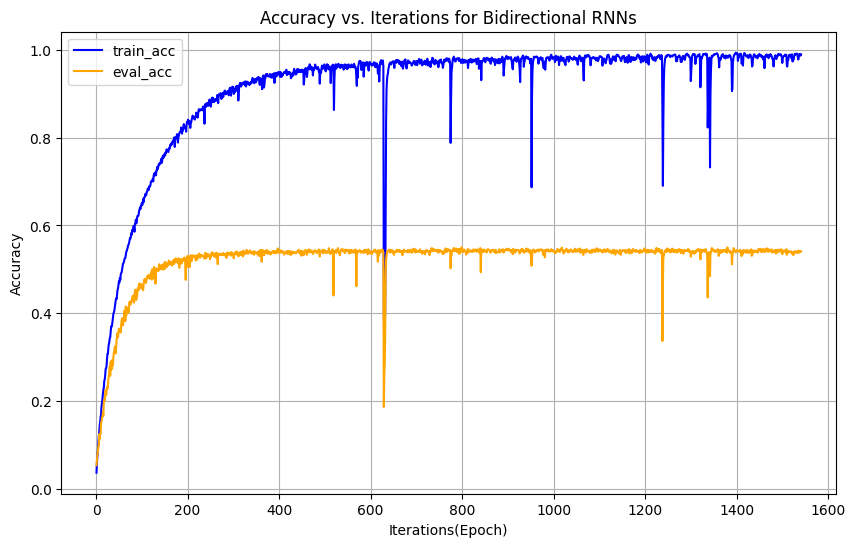

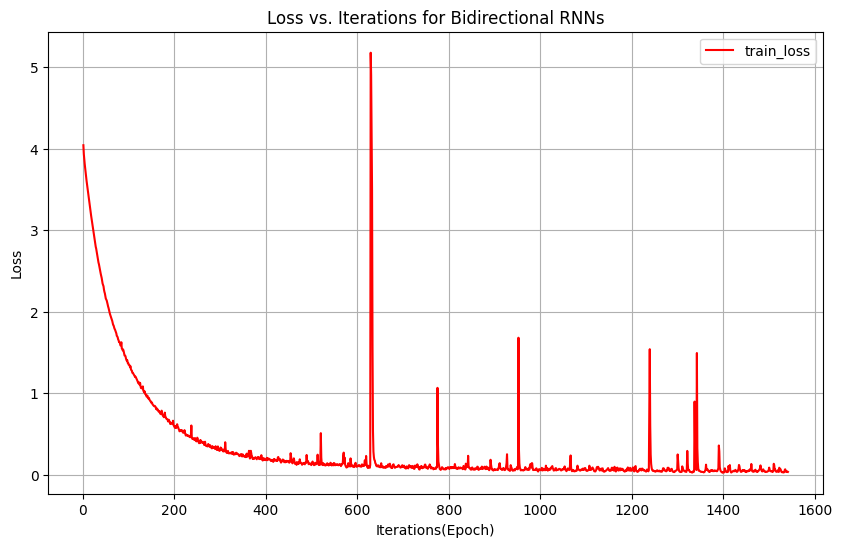

In [12]:
# plot train acc vs. iterations(epoch)
num_epochs = 1541
x_axis = list(range(1, num_epochs+1))
plt.figure(figsize=(10, 6))
# plot train acc
plt.plot(x_axis, bi_rnn_train_acc, color='blue')
# plot eval acc
plt.plot(x_axis, bi_rnn_eval_acc, color='orange')
#plt.xscale('log')
plt.xlabel('Iterations(Epoch)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iterations for Bidirectional RNNs')
plt.grid(True)
plt.legend(['train_acc', 'eval_acc'])
plt.show()

# plot train loss vs. iterations(epoch)
plt.figure(figsize=(10, 6))
plt.plot(x_axis, bi_rnn_train_loss, color='red')
#plt.xscale('log')
plt.xlabel('Iterations(Epoch)')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations for Bidirectional RNNs')
plt.grid(True)
plt.legend(['train_loss'])
plt.show()

In [13]:
# Evaluate the rnn model
bi_rnn_model.eval()  
correct = 0
total = 0

with torch.inference_mode():
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = bi_rnn_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Accuracy on the test set: 53.96711937097927%


## LSTM Model 

In [6]:
### Xinyu(Xiyah) Chang ###

# Define LSTM Model
# Need a input with shape (, 1000, 204)
class MusicEmotionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MusicEmotionLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # batch_first=True gives the input and output tensors in the format:
        # (batch, seq, feature) instead of (seq, batch, feature)
        # batch: 
        # seq: which is timestep, here should be 1000
        # feature: 204
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully Connected Layer output the prediction
        # batchnorm is usually used before activation func
        # dropout is usually used after activation func
        # use batchnorm before dropout: 
        #   first stabalize data then pass to dropout layer
        self.fc = nn.Sequential(
            nn.Linear(num_layers * hidden_size, hidden_size), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2), 

            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2), 

            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        # Initialize hidden and cell states
        # x.size(0) is batch size
        # Bidirectional Rnn returns 
        # h0: tensor of shape (Number of Layers, Batchsize, hidden_size)
        h0 = torch.rand(self.num_layers * num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.rand(self.num_layers * num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward
        output, (final_ht, final_ct) = self.lstm(x, (h0, c0))
        #print(f"final_ht: {final_ht.shape}")

        return self.fc(final_ht[0])
### Xinyu(Xiyah) Chang ###

In [7]:
# Model Params
input_size = 204     # seq in (batch, seq, feature)
hidden_size = 128    # Can adjust based on model complexity and dataset, used: 128
num_layers = 1       # Number of RNN layers, 1 or 2, 1 is better by training
num_classes = 59      # 59
learning_rate = 3e-4 # Can adjust this learing rate， 1e-4, 3e-4, 1e-3, 3e-3
num_epochs = 2000      # Number of epochs
batch_size = 128     # size of batch

lstm_rnn_model = MusicEmotionLSTM(input_size, hidden_size, num_layers, num_classes)

# Use DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(dataset=eval_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Assuming use of CrossEntropyLoss and an optimizer Adam
criterion = nn.CrossEntropyLoss()

In [8]:
### Xinyu(Xiyah) Chang ###

# Define the device 
# "cuda", "mps", "cpu"
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda')

# Move model to the chosen device
lstm_rnn_model = lstm_rnn_model.to(device)
lstm_rnn_optimizer = optim.AdamW(lstm_rnn_model.parameters(), lr=learning_rate)

total_batches = math.ceil( X_train.shape[0] / batch_size)
#total_batches = 7
lstm_rnn_model.train()  

# record train acc and loss
lstm_rnn_train_acc = []
lstm_rnn_train_loss = []

# record eval acc
lstm_rnn_eval_acc = []

for epoch in trange(num_epochs):
    running_loss = 0.0
    prog = enumerate(train_loader) #tqdm(enumerate(train_loader), total=total_batches, desc=f'Epoch {epoch+1}/{num_epochs}')

    # initialize accuracy count for each new epoch
    correct = 0
    total = 0

    for i, (inputs, labels) in prog:
        # Move data to the chosen device
        # print(inputs)
        inputs, labels = inputs.to(device), labels.to(device)
        # print(inputs.shape)

        # Forward pass
        outputs = lstm_rnn_model(inputs)
        # print(outputs.shape)
        # print(outputs, labels)
        # break
        loss = criterion(outputs, labels)

        # Zero the parameter gradients
        lstm_rnn_optimizer.zero_grad(set_to_none=False)

        # Backward pass and optimize
        loss.backward()

        # clip gradient to prevent explosion
        # torch.nn.utils.clip_grad_norm_(lstm_rnn_model.parameters(), 20.0)
        lstm_rnn_optimizer.step()

        running_loss += loss.item()
        __, predicted = torch.max(outputs.data, dim=1)
        # print(f"predicted: {predicted}")
        # print(f"labels: {labels}")
        # print((predicted==labels).sum())   # tensor(41, device='mps:0')
        correct += (predicted==labels).sum().item()                         # Easily getting Error!
                                                    # before modifying, this part I forgot to add up "total" for all batches loops
        total += labels.size(0)
        #print(ct_acc)

    # calculate average loss and acc over training batches
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    lstm_rnn_train_acc.append(epoch_acc)
    lstm_rnn_train_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc_train: {epoch_acc:.4f}')

    # evaluate using eval for each epoch
    lstm_rnn_model.eval() 

    with torch.inference_mode():
        eval_correct=0
        eval_total=0
        for i, (inputs, labels) in enumerate(eval_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lstm_rnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

        eval_accuracy = eval_correct / eval_total
        lstm_rnn_eval_acc.append(eval_accuracy)
        print(f'Validation Accuracy: {eval_accuracy:.4f}%')
    
    # set the model back to train mode
    lstm_rnn_model.train()

### Xinyu(Xiyah) Chang ###

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1/2000, Loss: 4.1022, Acc_train: 0.0240
Validation Accuracy: 0.0454%
Epoch 2/2000, Loss: 4.0183, Acc_train: 0.0370
Validation Accuracy: 0.0483%
Epoch 3/2000, Loss: 3.9816, Acc_train: 0.0478
Validation Accuracy: 0.0572%
Epoch 4/2000, Loss: 3.9484, Acc_train: 0.0506
Validation Accuracy: 0.0651%
Epoch 5/2000, Loss: 3.9050, Acc_train: 0.0627
Validation Accuracy: 0.0747%
Epoch 6/2000, Loss: 3.8888, Acc_train: 0.0643
Validation Accuracy: 0.0729%
Epoch 7/2000, Loss: 3.8598, Acc_train: 0.0703
Validation Accuracy: 0.0740%
Epoch 8/2000, Loss: 3.8310, Acc_train: 0.0755
Validation Accuracy: 0.0797%
Epoch 9/2000, Loss: 3.8100, Acc_train: 0.0811
Validation Accuracy: 0.0890%
Epoch 10/2000, Loss: 3.7786, Acc_train: 0.0895
Validation Accuracy: 0.0930%
Epoch 11/2000, Loss: 3.7523, Acc_train: 0.0940
Validation Accuracy: 0.0965%
Epoch 12/2000, Loss: 3.7251, Acc_train: 0.1017
Validation Accuracy: 0.1030%
Epoch 13/2000, Loss: 3.6940, Acc_train: 0.1065
Validation Accuracy: 0.1076%
Epoch 14/2000, Loss: 

KeyboardInterrupt: 

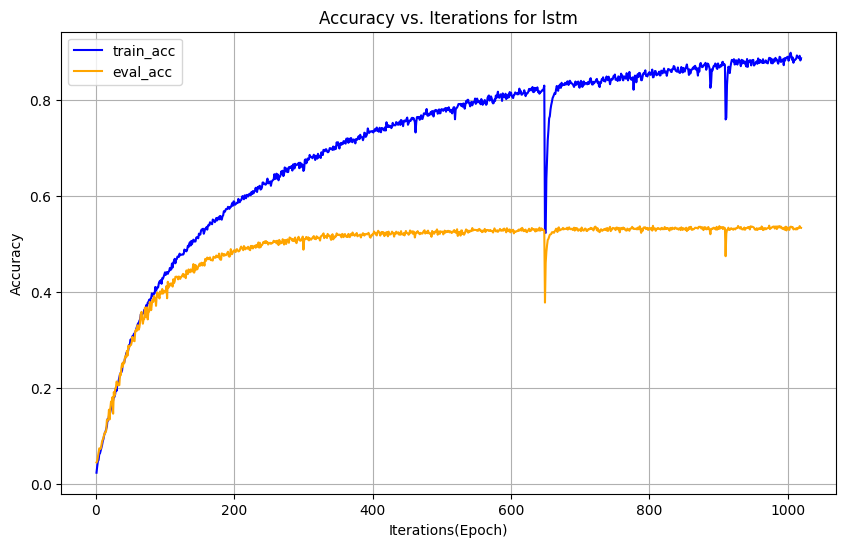

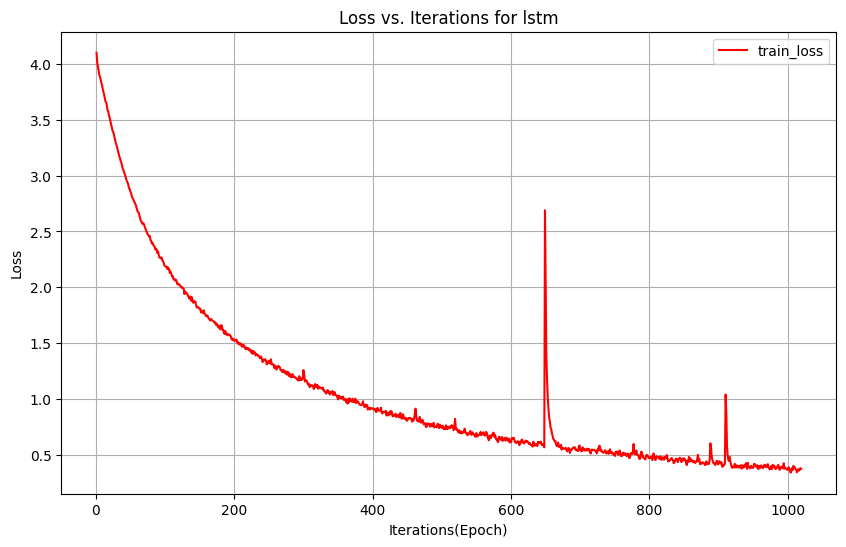

In [10]:
# plot train acc vs. iterations(epoch)
num_epochs = 1019
x_axis = list(range(1, num_epochs+1))
plt.figure(figsize=(10, 6))
# plot train acc
plt.plot(x_axis, lstm_rnn_train_acc, color='blue')
# plot eval acc
plt.plot(x_axis, lstm_rnn_eval_acc, color='orange')
#plt.xscale('log')
plt.xlabel('Iterations(Epoch)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iterations for lstm')
plt.grid(True)
plt.legend(['train_acc', 'eval_acc'])
plt.show()

# plot train loss vs. iterations(epoch)
plt.figure(figsize=(10, 6))
plt.plot(x_axis, lstm_rnn_train_loss, color='red')
#plt.xscale('log')
plt.xlabel('Iterations(Epoch)')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations for lstm')
plt.grid(True)
plt.legend(['train_loss'])
plt.show()

In [11]:
# Evaluate the lstm model
lstm_rnn_model.eval()  
correct = 0
total = 0

with torch.inference_mode():
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = lstm_rnn_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Accuracy on the test set: 52.60900643316655%
